In [1]:
import cv2
import time
import numpy as np
import utils
import sys
import os.path

import matplotlib.pyplot as plt

kinect = utils.Kinect()
image_dir = "img_for_paper"

In [2]:
def save_image(filename, image):
  pth = os.path.join(image_dir, filename)
  if not(np.issubdtype(image.dtype, np.integer)):
    img = (image - image.min())/(image.max() - image.min())*255
    img = img.astype(np.uint8)
  else:
    img = image
  cv2.imwrite(pth, img)

(720, 1280, 3)


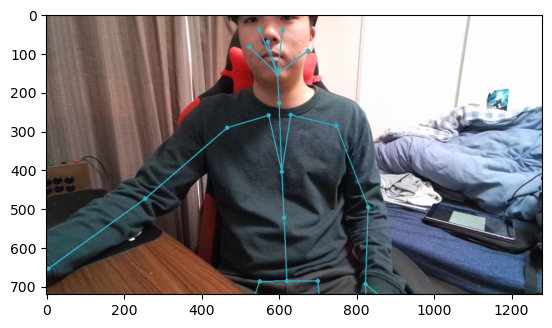

In [12]:
depth_img, (neck, pelvis), color_skelton = kinect.update()
print(color_skelton[:,:,:3].shape)
plt_skelton = cv2.cvtColor(color_skelton[:,:,:3], cv2.COLOR_BGRA2RGB)
plt.imshow(plt_skelton)

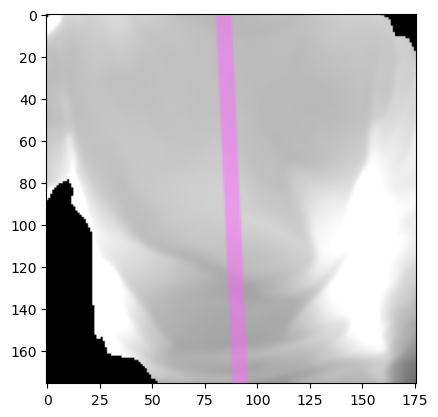

In [13]:
h,w = depth_img.shape
vertical_spine = int( max( abs(neck[0] - pelvis[0]), abs(neck[1] - pelvis[1]) ) /2 )
center_spine = (neck+pelvis)//2
left_top = (center_spine - vertical_spine).astype(np.uint16)
right_bottom = (center_spine + vertical_spine).astype(np.uint16)
cropped_depth = depth_img[
  max(0,left_top[1]) : min(w,right_bottom[1]),
  max(0,left_top[0]) : min(h,right_bottom[0])
]
cropped_neck, cropped_pelvis = neck-left_top, pelvis-left_top

depth_view = utils.mapCvt(depth_img.copy(), 540, 256)
depth_view = np.stack([depth_view, depth_view, depth_view], -1)
depth_view = (depth_view-depth_view.min())/(depth_view.max()-depth_view.min())*255
depth_view = depth_view.astype(np.uint8)

depth_view_shape = depth_view.copy()
cv2.line(depth_view_shape, neck.astype(np.int32), pelvis.astype(np.int32), (255,100,255), 5, cv2.LINE_AA)
cv2.rectangle(depth_view_shape, left_top.astype(np.int32), right_bottom.astype(np.int32), (100,255,100), 4, cv2.LINE_AA)
combined_depth = cv2.addWeighted(depth_view_shape, 0.6, depth_view, 0.4, 0)

cropped_depth_view = utils.mapCvt(cropped_depth.copy(), 540, 256)
cropped_depth_view = np.stack([cropped_depth_view, cropped_depth_view, cropped_depth_view], -1)
cropped_depth_view = (cropped_depth_view-cropped_depth_view.min())/(cropped_depth_view.max()-cropped_depth_view.min())*255
cropped_depth_view = cropped_depth_view.astype(np.uint8)

cropped_depth_view_shape = cropped_depth_view.copy()
cv2.line(cropped_depth_view_shape, cropped_neck.astype(np.uint8), cropped_pelvis.astype(np.uint8), (255,100,255), 5, cv2.LINE_AA)
combined_cropped_depth = cv2.addWeighted(cropped_depth_view_shape, 0.5, cropped_depth_view, 0.5, 0)

plt.imshow(combined_cropped_depth)

In [14]:
_,color_image = kinect.capture.get_transformed_color_image()

color_image = cv2.cvtColor(color_image, cv2.COLOR_BGRA2RGB)
shapes_image = color_image.copy()
cv2.line(shapes_image, neck.astype(np.uint32), pelvis.astype(np.uint32), (255,100,255), 4, cv2.LINE_AA)
cv2.rectangle(shapes_image, left_top, right_bottom, (100,255,100), 4, cv2.LINE_AA)
combined_color_image = cv2.addWeighted(color_image, 0.4, shapes_image, 0.6, 0)

In [15]:
N=5
spine_vec = cropped_neck - cropped_pelvis
slope = spine_vec[1]/spine_vec[0]

#計算用の座標グリッド
x_line = np.arange(cropped_depth.shape[0])
y_line = np.arange(cropped_depth.shape[1])
x_grid,y_grid = np.meshgrid(x_line, y_line)

gradation_distance = np.abs((y_grid-cropped_neck[1])-(x_grid-cropped_neck[0])*slope)
gradation_distance /= gradation_distance.max()

In [16]:
#領域分割
plot_color=np.array([(100,100,255), (100,255,100), (255,100,100), (100,255,255), (255,100,255), (255,255,100)], dtype=np.uint8)

split_map = cropped_depth.copy()
split_map = (split_map - split_map.min())/(split_map.max()-split_map.min())*255
split_map = np.stack([split_map,split_map, split_map], -1).astype(np.uint8)
gradation_split = x_grid + slope*y_grid
split_pos = np.stack( [np.linspace(cropped_neck[0], cropped_pelvis[0], N+1), np.linspace(cropped_neck[1], cropped_pelvis[1], N+1)], 1)

for i in range(N):
  point1, point2 = split_pos[i], split_pos[i+1]
  threshold1 = point1[0] + point1[1]*slope
  threshold2 = point2[0] + point2[1]*slope
  mask = np.where((gradation_split>threshold1)^(gradation_split>threshold2), True, False)
  region = (cropped_depth>0.0)&mask
  split_map[region] = plot_color[i]

In [17]:
#重みづけ
WEIGHT_METHOD = utils.Weight_Method
METHOD_NAMES = WEIGHT_METHOD.keys()
weight_maps = {}
weighted_regions = {}
variance = 0.5
for method_name in METHOD_NAMES:
  weight_maps[method_name] = WEIGHT_METHOD[method_name](gradation_distance, variance)
  weighted_regions[method_name] = split_map.astype(np.float32)*np.stack([weight_maps[method_name], weight_maps[method_name], weight_maps[method_name]], -1)
  weighted_regions[method_name] = weighted_regions[method_name].astype(np.uint8)

In [18]:
#領域マップと深度マップを合成
depth_map = utils.mapCvt(cropped_depth.copy(), 540, 256)

depth_weighted = {}
for method_name in METHOD_NAMES:
  depth_weighted[method_name] = depth_map*weight_maps[method_name]
  depth_weighted[method_name] = depth_weighted[method_name]
  depth_weighted[method_name] = depth_weighted[method_name].astype(np.uint8)

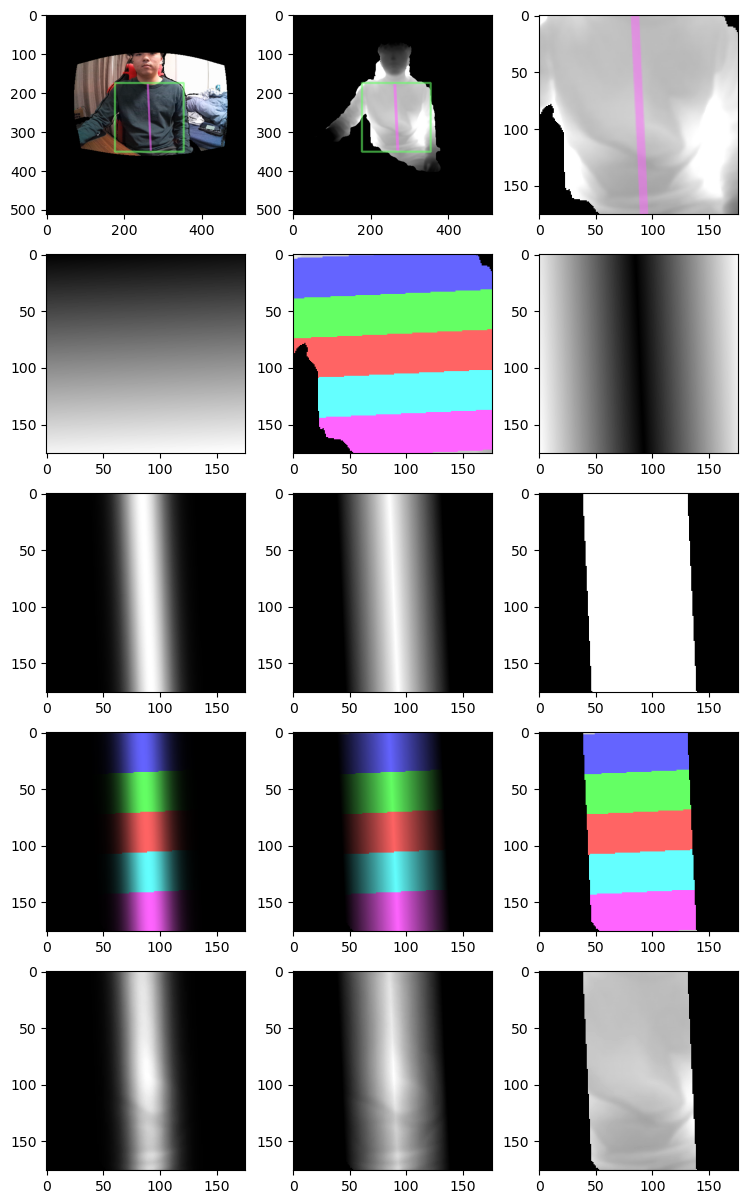

In [19]:
fig_height = 5
plt.figure(figsize=(9,3*fig_height))

plt.subplot(fig_height,3,1); plt.imshow(combined_color_image)
plt.subplot(fig_height,3,2); plt.imshow(combined_depth)
plt.subplot(fig_height,3,3); plt.imshow(combined_cropped_depth)
plt.subplot(fig_height,3,4); plt.imshow(gradation_split, cmap="grey")
plt.subplot(fig_height,3,5); plt.imshow(split_map)
plt.subplot(fig_height,3,6); plt.imshow(gradation_distance, cmap="grey")

for i,(k,v) in enumerate(weight_maps.items()):
  plt.subplot(fig_height,3,7+i); plt.imshow(v,  cmap="grey")
  plt.subplot(fig_height,3,10+i); plt.imshow(weighted_regions[k])
  plt.subplot(fig_height,3,13+i); plt.imshow(depth_weighted[k], cmap="grey")
  
save_image("line-framed_color_image.jpg", cv2.cvtColor(combined_color_image, cv2.COLOR_BGR2RGB))
save_image("line-framed_depth_image.jpg", combined_depth)
save_image("line_cropped_depth_image.jpg", combined_cropped_depth)
save_image("gradation_split.jpg", gradation_split)
save_image("split_map.jpg", split_map)
save_image("gradation_distance.jpg", gradation_distance)
for k in METHOD_NAMES:
  save_image(f"weight_map({k}).jpg", weight_maps[k])
  save_image(f"weighted_regions({k}).jpg", weighted_regions[k])
  save_image(f"weighted_depth_image({k}.jpg", depth_weighted[k])